# Geometric Brownian Motion Demo

Geometric Brownian Motion (GBM) is a continuous stochastic process in which a logarithm of varying parameter follows a Brownian Motion, given by:

$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2}) + \sigma W_t}$,

where $S_0$ is the initial value, $\mu$ and $\sigma$ are drift and difussion coefficients, respectively, and $W_t$ is a (Standard) Brownian Motion.

GBM is commonly used to model stock prices and options payoffs. 

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats
import pandas as pd
import time
from matplotlib import pyplot
import matplotlib.pyplot as plt


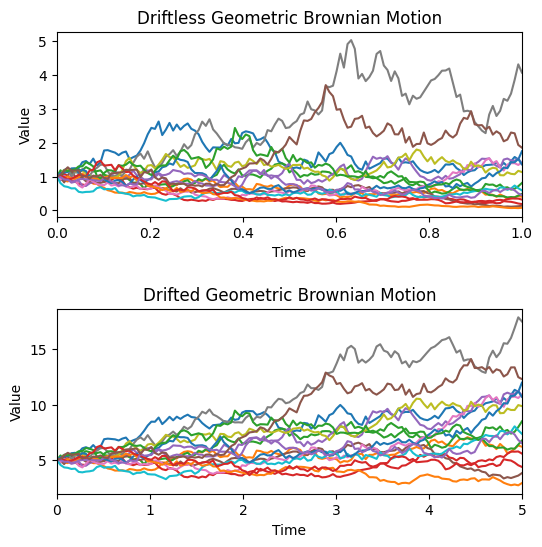

In [2]:
n = 16
discrete_distrib = qp.Lattice(2**7)
geometric_brownian_motions = {
    'Driftless Geometric Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib),
    'Drifted Geometric Brownian Motion': qp.GeometricBrownianMotion(discrete_distrib,t_final=5,initial_value=5,drift=0.1, diffusion=0.2)}
fig,ax = pyplot.subplots(nrows=len(geometric_brownian_motions),ncols=1,figsize=(6,3*len(geometric_brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,gbm) in enumerate(geometric_brownian_motions.items()):
    t = gbm.gen_samples(n)
    t_w_init = np.hstack([gbm.initial_value*np.ones((n,1)),t])
    tvec_w_0 = np.hstack([0,gbm.time_vec])
    ax[i].plot(tvec_w_0,t_w_init.T)
    ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
    ax[i].set_title(name)
    ax[i].set_xlabel('Time')  
    ax[i].set_ylabel('Value') 
plt.subplots_adjust(hspace=0.5)
plt.show()


In [18]:
def plot_gbm_paths(gbm, n, title):
    
    t = gbm.gen_samples(n)
    t_w_init = np.concatenate([gbm.initial_value * np.ones((n, 1)), t], axis=1)
    tvec_w_0 = np.concatenate([[0], gbm.time_vec])

    # Plot the paths
    plt.figure(figsize=(7, 4))
    for i in range(n):
        plt.plot(tvec_w_0, t_w_init[i, :])
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]])
    plt.show()

# 

GBM using Standard Uniform Distribution 

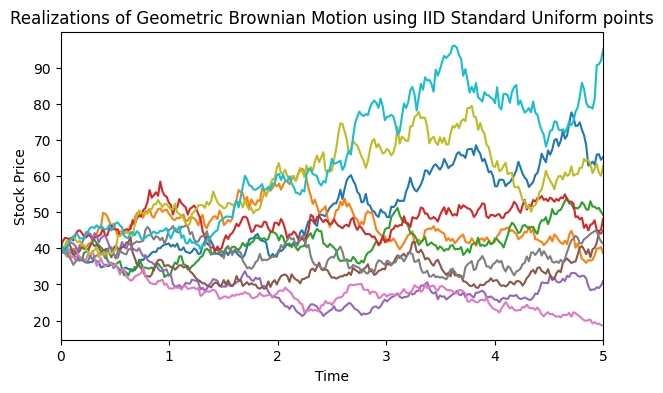

In [19]:

gbm_iid = qp.GeometricBrownianMotion(qp.IIDStdUniform(2**8), t_final=5, initial_value=40, drift=0.1, diffusion=0.2)
plot_gbm_paths(gbm_iid, n=10, title='Realizations of Geometric Brownian Motion using IID Standard Uniform points')

GBM using low-discrepancy Lattice sequence distrubtion 

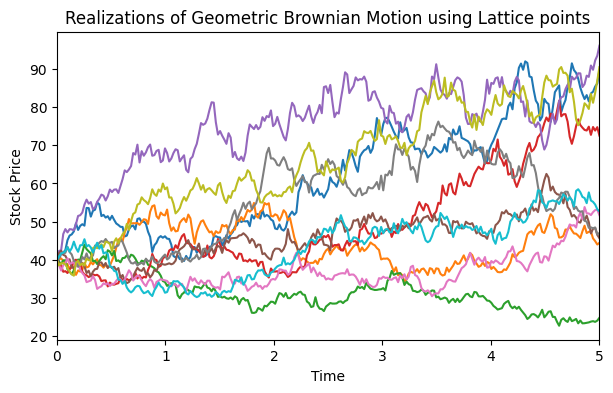

In [7]:
gbm_lattice = qp.GeometricBrownianMotion(qp.Lattice(2**8), t_final=5, initial_value=40, drift=0.1, diffusion=0.2)
plot_gbm_paths(gbm_lattice, n=10, title='Realizations of Geometric Brownian Motion using Lattice points')